# Geocentric models (lecture 3)

> https://youtu.be/tNOu-SEacNU

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.patches as patches

## Introduction

An model (statistical) may provide good predictions, even if it's (causally) completely wrong.

Linear regression is an example of a statistical model that predicts well, but generally fails to correctly explain causality since few phenomena are actually linearly related.

Case in point, ancient astronomers predicted the planetary retrograde phenomenon (planets zig-zags across the sky) within a geocentric model. They assumed the wrong thing, but the predictions worked anyway. In the geocentric model planets orbit around the Earth in epicycles, that is orbits on orbits. We now know that a different model (the iliocentric model) is a better representation of the solar system. The iliocentric model simultaneously predicts as well and correctly explains how planets move, namely in elliptic orbits around the sun. 

### Where do normal or gaussian distributions come from?

Generative argument: many small errors accumulate to the normal distribution because:
- small cumulative errors can be generated in many more ways than big cumulative errors

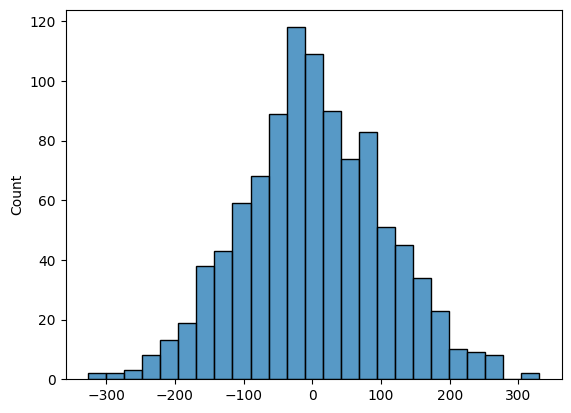

In [12]:
def football_flip(n, rounds):
    pos = np.zeros(n)
    for _ in range(rounds):
        delta = np.random.choice([-1, 1], size=n)
        pos += delta
    return pos

pos = football_flip(n=int(1e3), rounds=int(1e4))
sns.histplot(pos)
plt.show()

### Why are normal distributions a good first assumption?

They make the least claims about the distribution other than a central tendency and a variation around the mean.  

> A variable does not have to be (actually) normally distribution for normal models to be useful. It's a machine for estimating mean and variance.

## 1. Modeling weight as a function of height

Variables:
- H = height
- W = weight
- U = unobserved influences on weight

Causal model:

```
                               ┌────┐
  H   ────────▶  W   ◀─────────│ U  │
                               └────┘
```


## 2. Scientific/generative model

Formulas:

$$
\begin{align}
W & = & \beta \cdot H + U \\
U & \sim & Normal(0, \sigma) \\
H & \sim & Uniform(130, 170) \\
\end{align}
$$


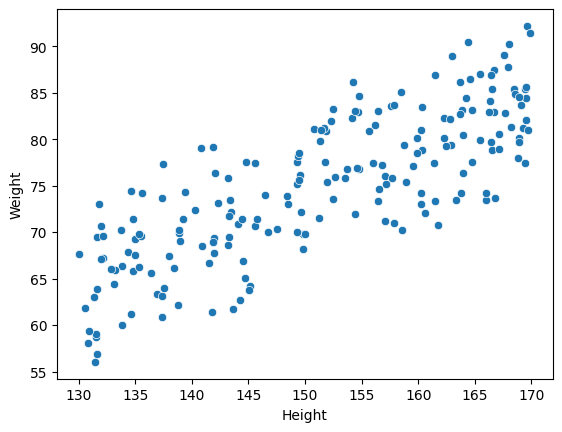

Bad pipe message: %s [b"\x1dv\x1e*-l\x13J0VI\xcc^\xd0\x96\x01)Q \x17\xcb\x15\xa0l'\x13\xca]\xf2\x7f\xce\xfd\xda\x1bH\x95A\xafN\x88\xbf\xec\xbaC\xe4}\xecG\x90;\n\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00"]
Bad pipe message: %s [b'i/\xe9\x08\x97\x91p\xd5>C\x1e\x97\xa3V\xac\x10\xd8\n QU\x17\xd8\x87\x05\xbd\x8a\xc3\x90T\x10)M\xd895\xf8C\x17\xd9\x9cA\x00\x94d\xbc]\xb9\xff\xf0o\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04', b'\x01\x02']
Bad pipe message: %s [b"\xacZ<\xfc$~\xf0\x87\xe02)\xba\xd7[8\x10\xce\xec\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n"]
Bad pipe message: %s [b'|\x0c\x81\xdfX&\x90D<\xf2\x99t\xe3\xc1\xdd\xa0\xf1\x04\x00\x00>\xc0\x14\xc0\n\x009\x008

In [13]:
def sim_weight(H, beta, sd):
    U = np.random.normal(loc=0, scale=sd, size=len(H))
    W = beta*H + U
    return W

n = 200
heights = np.random.uniform(low=130, high=170, size=n)
weights = sim_weight(heights, beta=0.5, sd=5)
sns.scatterplot(x=heights, y=weights)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

## 3. Statistical model (estimator)

Linear regression:

$$
E(W_i \mid H_i) = \alpha + \beta \cdot H_i
$$

Estimators are usually not exactly like generative model. Allows us to show us problems with generative model.

Goal: 
- Estimate how the average weight changes with height

### Posterior distribution

The only kind of estimator in Bayesian inference, but driven by different generative models.

$$
Pr(\alpha, \beta, \sigma \mid H_i, W_i) = \frac{Pr(W_i \mid H_i, \alpha, \beta, \sigma)Pr(\alpha, \beta, \sigma)}{Z}
$$

Variables
- Observed (known from observation, so don't need posterior distribution): $H, W$ 
- Unobserved (need to develop posterior distribution for them): $\alpha, \beta, \sigma$

Explanation of formula:
- LHS = posterior distribution of specific line
- RHS (upper, factor 1) = the number of ways we could see observations.
- RHS (upper, factor 2) = prior (i.e., the previous posterior distribution)
- RHS (lower) = normalising constant


### Constructing prior predictive distribution

Prior should express scientific knowledge, but *softly*. Should allow predictions that are not *crazy*, before seeing data.

Selecting sane priors:
- Humans with zero height weigh zero kg, therefore $\alpha \sim Normal(0, 10)$.
- Weight increases with height on average, and weight < height, therefore $\beta \sim Uniform(0,1)$ 
- Noise must be positive, but we don't know how much, therefore $\sigma \sim Uniform(0,10)$

Generate these priors, e.g., by testing what generated observations look like with these priors.

### Visualising priors

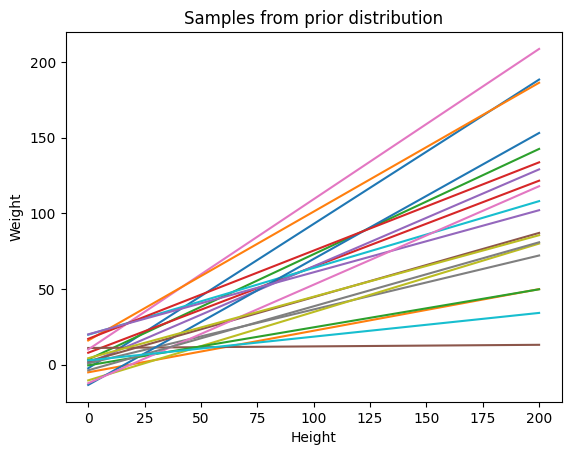

In [21]:
n = 20
alpha = np.random.normal(0, 10, size=n)
beta = np.random.uniform(0, 1, size=n)
sigma = np.random.uniform(0, 10, size=n)
x0 = 0
x1 = 200

for i in range(n):
    y0 = alpha[i]
    y1 = beta[i]*x1 + alpha[i]
    plt.plot([x0, x1], [y0, y1])
plt.title('Samples from prior distribution')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()


### Quadratic approximation

TODO

## 4. Validate model

TODO, because we didn't finish the statistical model (quap)

Bare mimimum:
- Test statistical model with simulated observations from scientific model